In [1]:
!pip install split-folders


In [2]:
import numpy as np
import pickle
import cv2
import splitfolders
import tensorflow as tf 
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils.image_utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from re import sub
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32
CHANNELS = 3
EPOCHES= 100

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/corn-or-maize-leaf-disease-dataset/data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [5]:
import os
import glob as gb
path = "//kaggle//input//corn-or-maize-leaf-disease-dataset//data"
size=[]
for folder in os.listdir(path):
    files = gb.glob(pathname=str(path+"//"+folder+"/*.jpg"))
    for file in files:
        image=plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(256, 256, 3)      1323
(768, 1024, 3)        8
(1200, 675, 3)        7
(2448, 3264, 3)       7
(900, 1200, 3)        5
                   ... 
(1024, 650, 3)        1
(640, 360, 3)         1
(371, 788, 3)         1
(200, 250, 3)         1
(378, 420, 3)         1
Length: 265, dtype: int64

In [6]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [7]:
len(dataset)

131

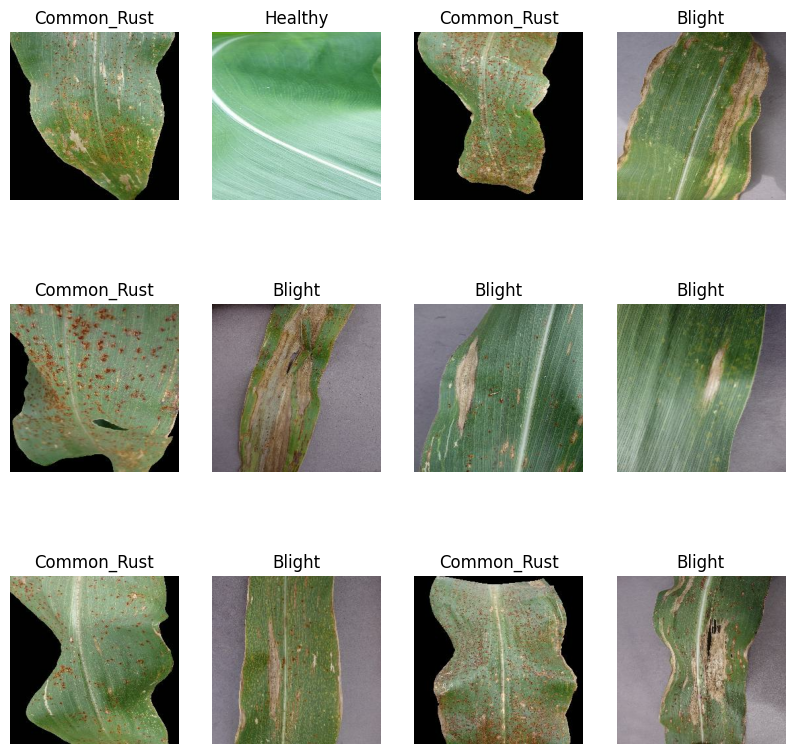

In [8]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [11]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 104

Length of Validation Dataset is 13

Length of Testing Dataset is 14


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
])

In [15]:
n_classes = 4
input_shape = (BATCH_SIZE,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [16]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [17]:
history = model.fit(
train_ds,
epochs=60,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/60
104/104 [==============================] - 45s 205ms/step - loss: 0.6891 - accuracy: 0.7307 - val_loss: 0.3890 - val_accuracy: 0.8269
Epoch 2/60
104/104 [==============================] - 11s 105ms/step - loss: 0.4318 - accuracy: 0.8192 - val_loss: 0.3358 - val_accuracy: 0.8486
Epoch 3/60
104/104 [==============================] - 11s 109ms/step - loss: 0.3785 - accuracy: 0.8306 - val_loss: 0.3553 - val_accuracy: 0.8702
Epoch 4/60
104/104 [==============================] - 11s 103ms/step - loss: 0.3625 - accuracy: 0.8415 - val_loss: 0.3347 - val_accuracy: 0.8606
Epoch 5/60
104/104 [==============================] - 11s 109ms/step - loss: 0.3828 - accuracy: 0.8336 - val_loss: 0.2827 - val_accuracy: 0.8630
Epoch 6/60
104/104 [==============================] - 11s 104ms/step - loss: 0.3325 - accuracy: 0.8607 - val_loss: 0.2761 - val_accuracy: 0.8702
Epoch 7/60
104/104 [==============================] - 11s 103ms/step - loss: 0.3363 - accuracy: 0.8583 - val_loss: 0.3013 - val_ac

In [18]:
pip install visualkeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 14.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


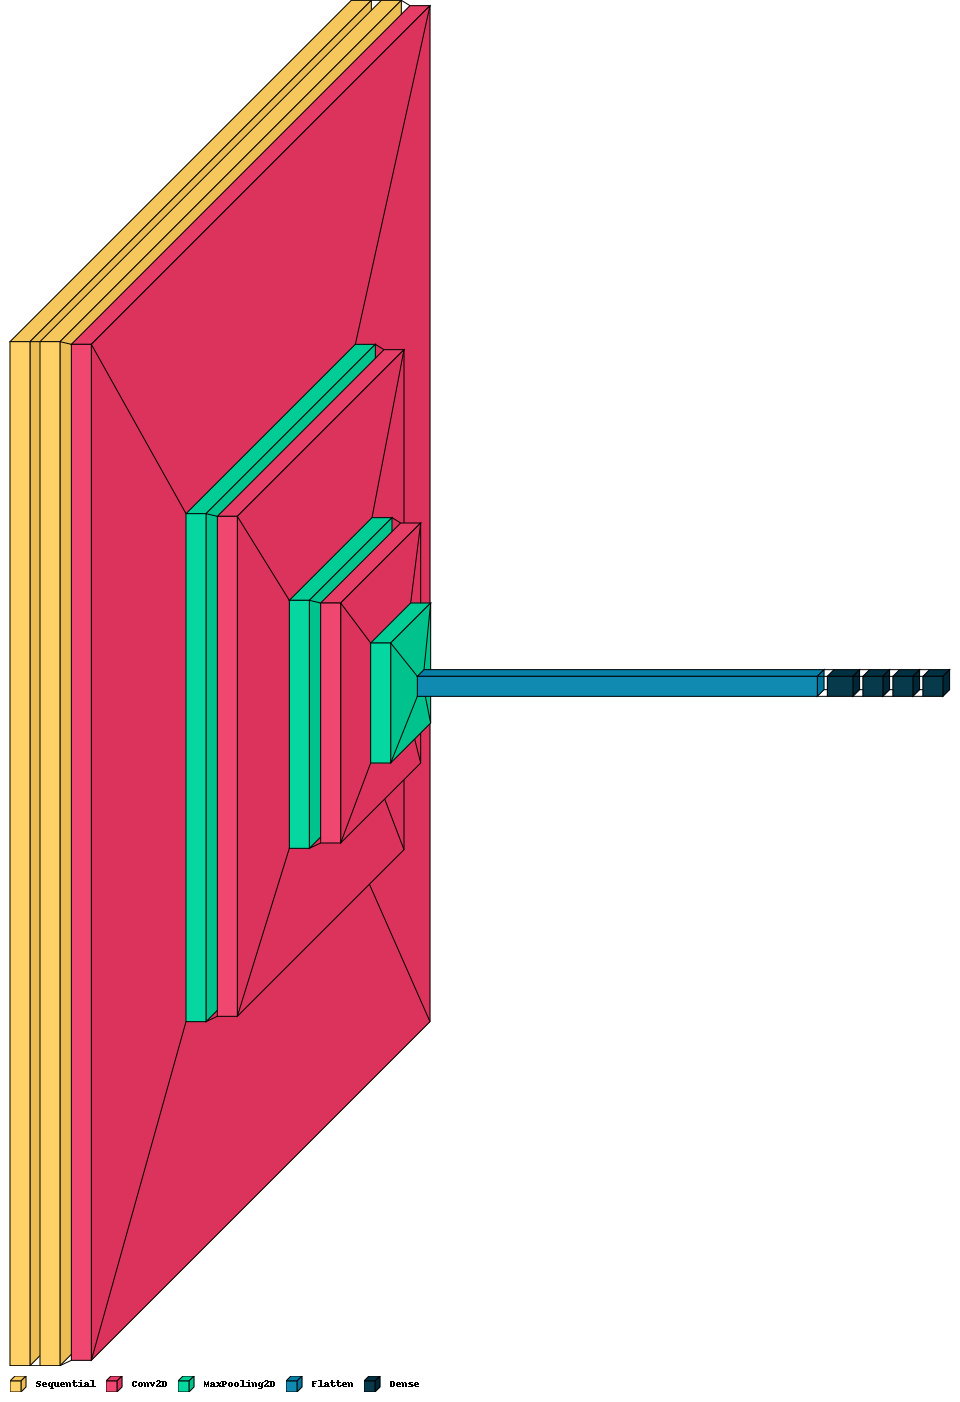

In [19]:
import visualkeras

from PIL import ImageFont
visualkeras.layered_view(model, legend=True)


In [20]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.689124,0.730746,0.389025,0.826923
1,0.431774,0.819194,0.335775,0.848558
2,0.378524,0.830626,0.355308,0.870192
3,0.362473,0.841456,0.334677,0.860577
4,0.382850,0.833634,0.282686,0.862981
5,0.332537,0.860710,0.276132,0.870192
6,0.336332,0.858303,0.301305,0.870192
7,0.299310,0.876354,0.256790,0.889423
8,0.299320,0.876655,0.240678,0.908654
9,0.254093,0.893201,0.234704,0.913462


In [21]:
import matplotlib.pyplot as plt

def CNN_Test_Save(name, model, history):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    #Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    #Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

    #print("[INFO] Saving model")
    #model.save(name)
    plt.savefig(name)


[INFO] Plotting model accuracy and Loss


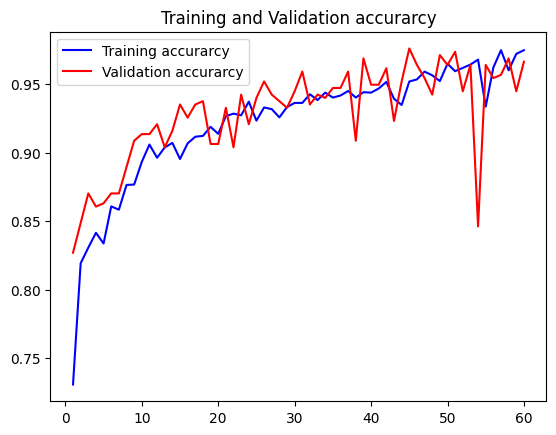

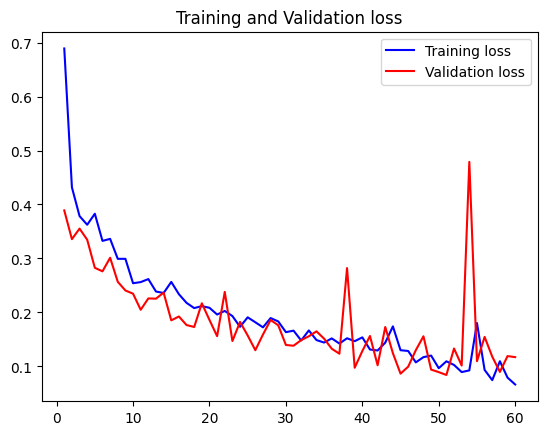

<Figure size 640x480 with 0 Axes>

In [22]:
CNN_Test_Save('CNN_model.png', model, history)

In [23]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(val_ds)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
13/13 [==============================] - 0s 19ms/step - loss: 0.1172 - accuracy: 0.9663
Test Accuracy: 96.63461446762085
